# Test Unfold 4
<hr style="border-top-width: 4px; border-top-color: #34609b;">
Test program for the class TUnfoldSys

Simple toy tests of the TUnfold package

Pseudo data (5000 events) are unfolded into three components
The unfolding is performed once without and once with area constraint

Ideally, the pulls may show that the result is biased if no constraint
is applied. This is expected because the true data errors are not known,
and instead the sqrt(data) errors are used.

 History:
 - Version 16.1, parallel to changes in TUnfold
 - Version 16.0, parallel to changes in TUnfold
 - Version 15, use L-curve scan to scan the average correlation




**Author:** Stefan Schmitt, DESY  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-mirror/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer (Beta)</a> from the macro found in the ROOT repository  on Thursday, January 19, 2017 at 04:36 PM.</small></i>

In [1]:
%%cpp -d
#include <TMath.h>
#include <TCanvas.h>
#include <TRandom3.h>
#include <TFitter.h>
#include <TF1.h>
#include <TStyle.h>
#include <TVector.h>
#include <TGraph.h>

#include "TUnfoldDensity.h"

using namespace std;

TRandom *rnd=0;

 A helper function is created: 

In [2]:
%%cpp -d
Int_t GenerateGenEvent(Int_t nmax,const Double_t *probability) {
   // choose an integer random number in the range [0,nmax]
   //    (the generator level bin)
   // depending on the probabilities
   //   probability[0],probability[1],...probability[nmax-1]
   Double_t f=rnd->Rndm();
   Int_t r=0;
   while((r<nmax)&&(f>=probability[r])) {
      f -= probability[r];
      r++;
   }
   return r;
}

 A helper function is created: 

In [3]:
%%cpp -d
Double_t GenerateRecEvent(const Double_t *shapeParm) {
   // return a coordinate (the reconstructed variable)
   // depending on shapeParm[]
   //  shapeParm[0]: fraction of events with Gaussian distribution
   //  shapeParm[1]: mean of Gaussian
   //  shapeParm[2]: width of Gaussian
   //  (1-shapeParm[0]): fraction of events with flat distribution
   //  shapeParm[3]: minimum of flat component
   //  shapeParm[4]: maximum of flat component
   Double_t f=rnd->Rndm();
   Double_t r;
   if(f<shapeParm[0]) {
      r=rnd->Gaus(shapeParm[1],shapeParm[2]);
   } else {
      r=rnd->Rndm()*(shapeParm[4]-shapeParm[3])+shapeParm[3];
   }
   return r;
}

In [4]:
  // switch on histogram errors
  TH1::SetDefaultSumw2();

  // random generator
  rnd=new TRandom3();

  // data and MC number of events
  Double_t const nData0=    500.0;
  Double_t const nMC0  =  50000.0;

  // Binning
  // reconstructed variable (0-10)
  Int_t const nDet=15;
  Double_t const xminDet=0.0;
  Double_t const xmaxDet=15.0;

  // signal binning (three shapes: 0,1,2)
  Int_t const nGen=3;
  Double_t const xminGen=-0.5;
  Double_t const xmaxGen= 2.5;

  // parameters
  // fraction of events per signal shape
  static const Double_t genFrac[]={0.3,0.6,0.1};

  // signal shapes
  static const Double_t genShape[][5]=
  {{1.0,2.0,1.5,0.,15.},
   {1.0,7.0,2.5,0.,15.},
   {0.0,0.0,0.0,0.,15.}};

  // define DATA histograms
  // observed data distribution
  TH1D *histDetDATA=new TH1D("Yrec",";DATA(Yrec)",nDet,xminDet,xmaxDet);

  // define MC histograms
  // matrix of migrations
  TH2D *histGenDetMC=new TH2D("Yrec%Xgen","MC(Xgen,Yrec)",
                           nGen,xminGen,xmaxGen,nDet,xminDet,xmaxDet);

  TH1D *histUnfold=new TH1D("Xgen",";DATA(Xgen)",nGen,xminGen,xmaxGen);

  TH1D **histPullNC=new TH1D* [nGen];
  TH1D **histPullArea=new TH1D* [nGen];
  for(int i=0;i<nGen;i++) {
  histPullNC[i]=new TH1D(TString::Format("PullNC%d",i),"pull",15,-3.,3.);
  histPullArea[i]=new TH1D(TString::Format("PullArea%d",i),"pull",15,-3.,3.);
  }

  // this method is new in version 16 of TUnfold
  cout<<"TUnfold version is "<<TUnfold::GetTUnfoldVersion()<<"\n";

  for(int itoy=0;itoy<1000;itoy++) {
  if(!(itoy %10)) cout<<"toy iteration: "<<itoy<<"\n";
  histDetDATA->Reset();
  histGenDetMC->Reset();

  Int_t nData=rnd->Poisson(nData0);
  for(Int_t i=0;i<nData;i++) {
     Int_t iGen=GenerateGenEvent(nGen,genFrac);
     Double_t yObs=GenerateRecEvent(genShape[iGen]);
     histDetDATA->Fill(yObs);
  }

  Int_t nMC=rnd->Poisson(nMC0);
  for(Int_t i=0;i<nMC;i++) {
     Int_t iGen=GenerateGenEvent(nGen,genFrac);
     Double_t yObs=GenerateRecEvent(genShape[iGen]);
     histGenDetMC->Fill(iGen,yObs);
  }
  /* for(Int_t ix=0;ix<=histGenDetMC->GetNbinsX()+1;ix++) {
     for(Int_t iy=0;iy<=histGenDetMC->GetNbinsY()+1;iy++) {
        cout<<ix<<iy<<" : "<<histGenDetMC->GetBinContent(ix,iy)<<"\n";
     }
     } */
  //========================
  // unfolding

  // switch off info messages
#ifndef DEBUG
  gErrorIgnoreLevel = 1001;
#endif

  TUnfoldSys unfold(histGenDetMC,TUnfold::kHistMapOutputHoriz,
                    TUnfold::kRegModeSize,TUnfold::kEConstraintNone);
  // define the input vector (the measured data distribution)
  unfold.SetInput(histDetDATA,0.0,1.0);

  // run the unfolding
  unfold.ScanLcurve(50,0.,0.,0,0,0);

  // fill pull distributions without constraint
  unfold.GetOutput(histUnfold);

  for(int i=0;i<nGen;i++) {
     histPullNC[i]->Fill((histUnfold->GetBinContent(i+1)-genFrac[i]*nData0)/
                         histUnfold->GetBinError(i+1));
  }

  // repeat unfolding on the same data, now with Area constraint
  unfold.SetConstraint(TUnfold::kEConstraintArea);

  // run the unfolding
  unfold.ScanLcurve(50,0.,0.,0,0,0);

  // fill pull distributions with constraint
  unfold.GetOutput(histUnfold);

  for(int i=0;i<nGen;i++) {
     histPullArea[i]->Fill((histUnfold->GetBinContent(i+1)-genFrac[i]*nData0)/
                         histUnfold->GetBinError(i+1));
  }

  }
  TCanvas *output = new TCanvas();
  output->Divide(3,2);

  gStyle->SetOptFit(1111);

  for(int i=0;i<nGen;i++) {
  output->cd(i+1);
  histPullNC[i]->Fit("gaus");
  histPullNC[i]->Draw();
  }
  for(int i=0;i<nGen;i++) {
  output->cd(i+4);
  histPullArea[i]->Fit("gaus");
  histPullArea[i]->Draw();
  }

TUnfold version is V17.1
toy iteration: 0
toy iteration: 10
toy iteration: 20
toy iteration: 30
toy iteration: 40
toy iteration: 50
toy iteration: 60
toy iteration: 70


Warning in <TUnfoldSys::SetInput>: One input bin has zero error, 1/error set to 1.000000.


toy iteration: 80
toy iteration: 90


Warning in <TUnfoldSys::SetInput>: One input bin has zero error, 1/error set to 1.000000.


toy iteration: 100
toy iteration: 110
toy iteration: 120
toy iteration: 130
toy iteration: 140
toy iteration: 150
toy iteration: 160
toy iteration: 170


Warning in <TUnfoldSys::SetInput>: One input bin has zero error, 1/error set to 1.000000.


toy iteration: 180
toy iteration: 190


Warning in <TUnfoldSys::SetInput>: One input bin has zero error, 1/error set to 1.000000.


toy iteration: 200


Warning in <TUnfoldSys::SetInput>: One input bin has zero error, 1/error set to 1.000000.


toy iteration: 210
toy iteration: 220


Warning in <TUnfoldSys::SetInput>: One input bin has zero error, 1/error set to 1.000000.


toy iteration: 230
toy iteration: 240
toy iteration: 250
toy iteration: 260
toy iteration: 270
toy iteration: 280


Warning in <TUnfoldSys::SetInput>: One input bin has zero error, 1/error set to 1.000000.


toy iteration: 290
toy iteration: 300


Warning in <TUnfoldSys::SetInput>: One input bin has zero error, 1/error set to 1.000000.


toy iteration: 310


Warning in <TUnfoldSys::SetInput>: One input bin has zero error, 1/error set to 1.000000.


toy iteration: 320
toy iteration: 330
toy iteration: 340
toy iteration: 350


Warning in <TUnfoldSys::SetInput>: One input bin has zero error, 1/error set to 1.000000.


toy iteration: 360
toy iteration: 370
toy iteration: 380


Warning in <TUnfoldSys::SetInput>: One input bin has zero error, 1/error set to 1.000000.


toy iteration: 390


Warning in <TUnfoldSys::SetInput>: One input bin has zero error, 1/error set to 1.000000.
Warning in <TUnfoldSys::SetInput>: One input bin has zero error, 1/error set to 1.000000.


toy iteration: 400
toy iteration: 410
toy iteration: 420
toy iteration: 430
toy iteration: 440
toy iteration: 450
toy iteration: 460
toy iteration: 470
toy iteration: 480
toy iteration: 490
toy iteration: 500


Warning in <TUnfoldSys::SetInput>: One input bin has zero error, 1/error set to 1.000000.


toy iteration: 510
toy iteration: 520


Warning in <TUnfoldSys::SetInput>: One input bin has zero error, 1/error set to 1.000000.
Warning in <TUnfoldSys::SetInput>: One input bin has zero error, 1/error set to 1.000000.


toy iteration: 530


Warning in <TUnfoldSys::SetInput>: One input bin has zero error, 1/error set to 1.000000.


toy iteration: 540
toy iteration: 550
toy iteration: 560
toy iteration: 570
toy iteration: 580


Warning in <TUnfoldSys::SetInput>: One input bin has zero error, 1/error set to 1.000000.
Warning in <TUnfoldSys::SetInput>: One input bin has zero error, 1/error set to 1.000000.


toy iteration: 590
toy iteration: 600


Warning in <TUnfoldSys::SetInput>: One input bin has zero error, 1/error set to 1.000000.


toy iteration: 610


Warning in <TUnfoldSys::SetInput>: One input bin has zero error, 1/error set to 1.000000.


toy iteration: 620
toy iteration: 630


Warning in <TUnfoldSys::SetInput>: One input bin has zero error, 1/error set to 1.000000.


toy iteration: 640
toy iteration: 650


Warning in <TUnfoldSys::SetInput>: One input bin has zero error, 1/error set to 1.000000.


toy iteration: 660


Warning in <TUnfoldSys::SetInput>: One input bin has zero error, 1/error set to 1.000000.


toy iteration: 670
toy iteration: 680


Warning in <TUnfoldSys::SetInput>: One input bin has zero error, 1/error set to 1.000000.


toy iteration: 690
toy iteration: 700
toy iteration: 710
toy iteration: 720
toy iteration: 730
toy iteration: 740
toy iteration: 750


Warning in <TUnfoldSys::SetInput>: One input bin has zero error, 1/error set to 1.000000.


toy iteration: 760
toy iteration: 770
toy iteration: 780
toy iteration: 790
toy iteration: 800
toy iteration: 810
toy iteration: 820
toy iteration: 830


Warning in <TUnfoldSys::SetInput>: One input bin has zero error, 1/error set to 1.000000.


toy iteration: 840
toy iteration: 850


Warning in <TUnfoldSys::SetInput>: One input bin has zero error, 1/error set to 1.000000.


toy iteration: 860
toy iteration: 870
toy iteration: 880
toy iteration: 890


Warning in <TUnfoldSys::SetInput>: One input bin has zero error, 1/error set to 1.000000.
Warning in <TUnfoldSys::SetInput>: One input bin has zero error, 1/error set to 1.000000.
Warning in <TUnfoldSys::SetInput>: One input bin has zero error, 1/error set to 1.000000.


toy iteration: 900
toy iteration: 910


Warning in <TUnfoldSys::SetInput>: One input bin has zero error, 1/error set to 1.000000.


toy iteration: 920
toy iteration: 930


Warning in <TUnfoldSys::SetInput>: One input bin has zero error, 1/error set to 1.000000.


toy iteration: 940
toy iteration: 950
toy iteration: 960


Warning in <TUnfoldSys::SetInput>: One input bin has zero error, 1/error set to 1.000000.
Warning in <TUnfoldSys::SetInput>: One input bin has zero error, 1/error set to 1.000000.


toy iteration: 970
toy iteration: 980


Warning in <TUnfoldSys::SetInput>: One input bin has zero error, 1/error set to 1.000000.


toy iteration: 990
 FCN=17.3145 FROM MIGRAD    STATUS=CONVERGED      59 CALLS          60 TOTAL
                     EDM=1.33067e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.53639e+02   6.05704e+00   1.02575e-02   3.01728e-06
   2  Mean        -1.21390e-01   3.38684e-02   6.92568e-05  -1.72950e-05
   3  Sigma        1.02094e+00   2.43696e-02   1.33049e-05   2.18204e-03
 FCN=8.19808 FROM MIGRAD    STATUS=CONVERGED      59 CALLS          60 TOTAL
                     EDM=6.85033e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.49698e+02   5.79213e+00   7.06055e-03   3.51186e-06
   2  Mean        -2.59551e-01   3.46939e-02   5.10123e-05   1.03984e-04
   3  Sigma   

Draw all canvases 

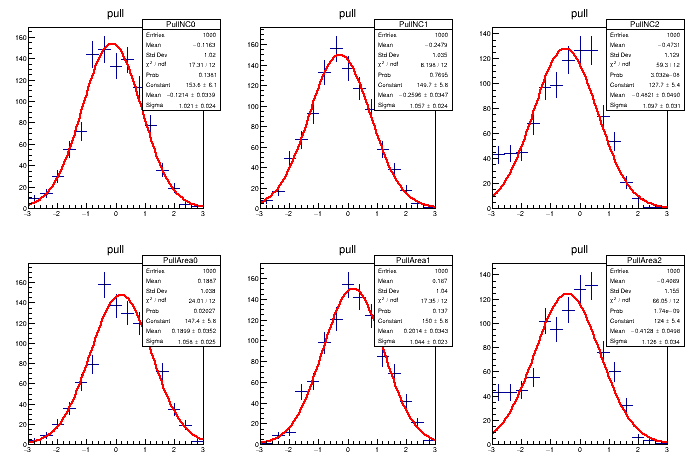

In [5]:
gROOT->GetListOfCanvases()->Draw()